In [1]:
import os
import math
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn
import os
import math
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import multivariate_normal
from scipy.stats import stats
from scipy.stats import nct
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import chisquare
from scipy.integrate import nquad
from scipy import stats
#from RegscorePy import *
from scipy.linalg import cholesky
from scipy.optimize import root

FiguresLoc = os.getcwd() + r'\\Figures\\'

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.06:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

def zscore(series):
    return (series - series.mean()) / series.std()

C:\Users\azl6s5v\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


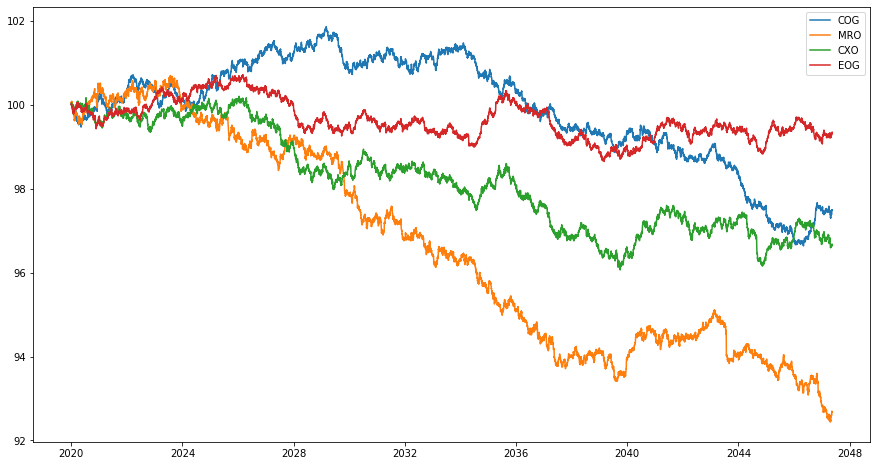

In [3]:
copSims = pd.read_csv(os.getcwd() + r'\\E&P_AdjClose.csv', index_col=0)
copSims.index = pd.to_datetime(copSims.index, format = '%m/%d/%Y')

copSims['cogsim'] = nct.ppf(copSims['COG'], 3.955232799442509, 0.062225211255520545, loc=-0.0015817476000228512, scale=0.01571554138387888)
copSims['mrosim'] = nct.ppf(copSims['MRO'], 3.1719275874252126, -0.17613490895159817, loc=0.0035944209990231247, scale=0.018989311009719335)
copSims['cxosim'] = nct.ppf(copSims['CXO'], 4.403837784862494, -0.2805201678245418, loc=0.006001743642228193, scale=0.017657796627197127)
copSims['eogsim'] = nct.ppf(copSims['EOG'], 4.546937597273587, -0.05599597096181681, loc=0.0010541064759504834, scale=0.014732827144459958)

copSims['cogidx'] = np.log(np.exp(copSims['cogsim']))
copSims['mroidx'] = np.log(np.exp(copSims['mrosim']))
copSims['cxoidx'] = np.log(np.exp(copSims['cxosim']))
copSims['eogidx'] = np.log(np.exp(copSims['eogsim']))

copSims['COGpx'] = 100 * (1 + copSims['cogidx'] / 100).cumprod()
copSims['MROpx'] = 100 * (1 + copSims['mroidx'] / 100).cumprod()
copSims['CXOpx'] = 100 * (1 + copSims['cxoidx'] / 100).cumprod()
copSims['EOGpx'] = 100 * (1 + copSims['eogidx'] / 100).cumprod()

enpStocks = copSims[['COGpx', 'MROpx','CXOpx','EOGpx']]
plt.figure(figsize=(15,8))
plt.plot(enpStocks)
plt.legend(['COG', 'MRO', 'CXO', 'EOG'])

                 COGpx       MROpx       CXOpx       EOGpx
Date                                                      
2020-01-01  100.019234  100.060102  100.004776  100.002906
2020-01-02  100.032030  100.035242  100.002764   99.997719
2020-01-03  100.047310  100.049788  100.043915  100.022049
2020-01-04   99.998662  100.049190  100.043849  100.024514
2020-01-05  100.022133  100.074539  100.048146  100.022362
Cointegrated Pairs => [('MROpx', 'CXOpx')]


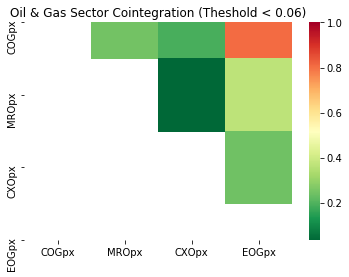

In [5]:
scores, pvalues, pairs = find_cointegrated_pairs(enpStocks[:1258]);
svm = seaborn.heatmap(pvalues, xticklabels=enpStocks.columns, yticklabels=enpStocks.columns,
                cmap='RdYlGn_r', mask = (pvalues >= 0.99))

print(enpStocks.head())
fig1 = svm.get_figure()
plt.title('Oil & Gas Sector Cointegration (Theshold < 0.06)')
print("Cointegrated Pairs => " + str(pairs))

In [8]:
#cointegration and correlation of each pair during formulation period

cog = enpStocks['COGpx']
mro = enpStocks['MROpx']
_, pvalue, _ = coint(cog[:], mro[:])
print('p-value of the cointegration test: {}'.format(round(pvalue, 4)))
print('COG vs. MRO correlation coefficient: {}'
      .format(round(np.log(cog[:1258]).diff().corr(np.log(mro[:1258]).diff()), 4)))

print('')

cxo = enpStocks['CXOpx']
eog = enpStocks['EOGpx']
_, pvalue, _ = coint(cxo[:], eog[:])
print('p-value of the cointegration test: {}'.format(round(pvalue, 4)))
print('CXO vs. EOG correlation coefficient: {}'
      .format(round(np.log(cxo[:1258]).diff().corr(np.log(eog[:1258]).diff()), 4)))

p-value of the cointegration test: 0.8972
COG vs. MRO correlation coefficient: 0.4995

p-value of the cointegration test: 0.4215
CXO vs. EOG correlation coefficient: 0.7929


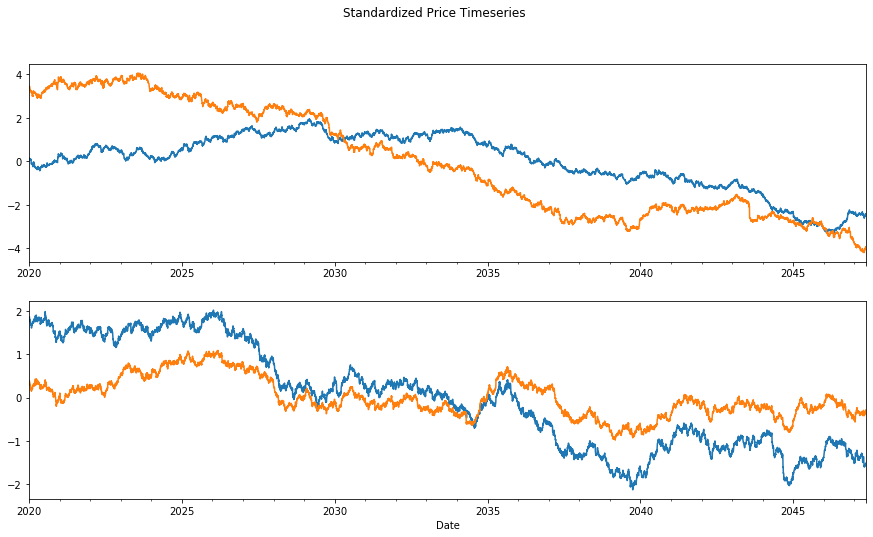

In [11]:
plt.figure(figsize=(15,8))
cog1 = cog - np.mean(cog)
mro1 = mro - np.mean(mro)
plt.suptitle("Standardized Price Timeseries")
plt.subplot(2,1,1)
#plt.title("COG vs MRO")
cog1.plot()
mro1.plot()
plt.xlabel('')

cxo1 = cxo - np.mean(cxo)
eog1 = eog - np.mean(eog)
plt.subplot(2,1,2)
#plt.title("CXO vs EOG")
cxo1.plot()
eog1.plot()
#plt.savefig(FiguresLoc + 'StandaridizePriceTimeSeries.png')

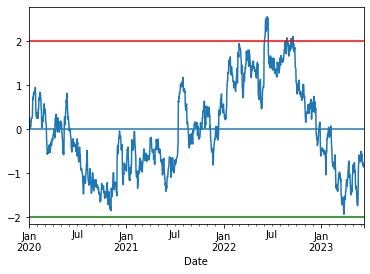

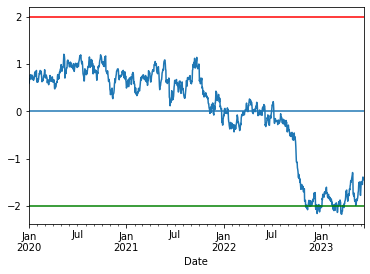

In [12]:
#normalized spreads for each pair during formulation period

spread1 = np.log(cog[:1258]) - np.log(mro[:1258])
zscore(spread1).plot()
plt.axhline(zscore(spread1).mean())
plt.axhline(2, color='red')
plt.axhline(-2, color='green')
plt.show()

print('')

spread2 = np.log(cxo[:1258]) - np.log(eog[:1258])
zscore(spread2).plot()
plt.axhline(zscore(spread2).mean())
plt.axhline(2, color='red')
plt.axhline(-2, color='green')
plt.show()

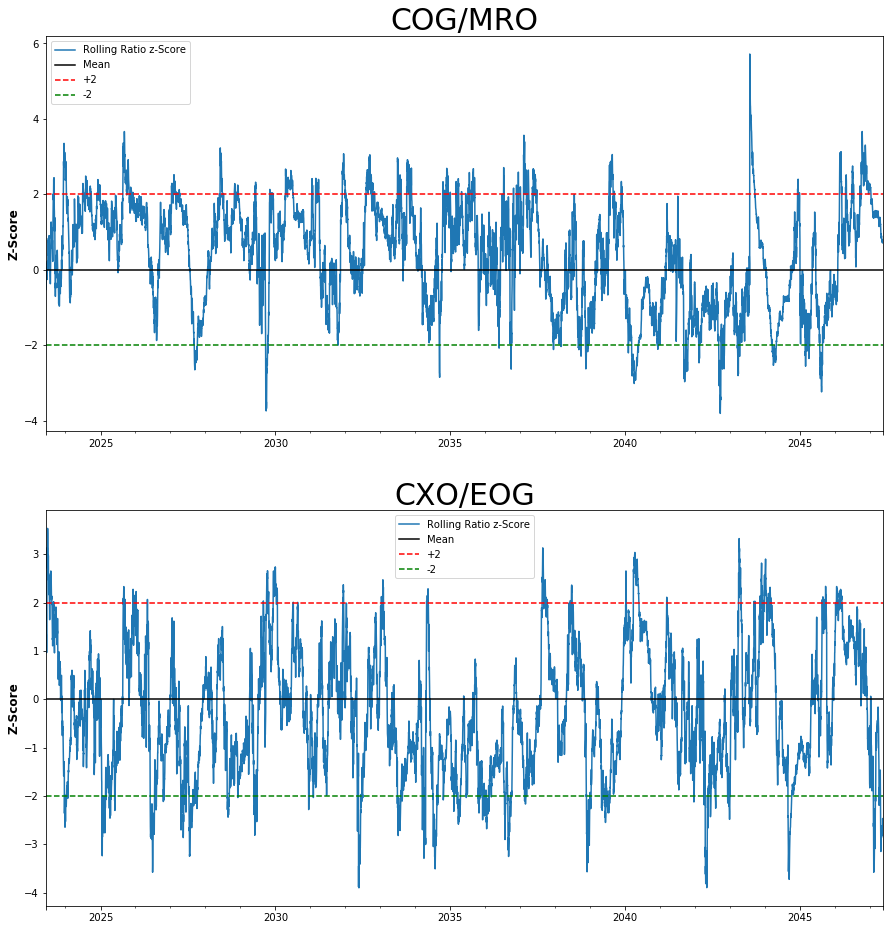

In [19]:
#live trading period signals

spread1_live = np.log(cog[1006:]) - np.log(mro[1006:])
spread_ltma1 = spread1_live.rolling(window=252, center=False).mean()
std_ltma1 = spread1_live.rolling(window=252, center=False).std()
zscore_signal1 = (spread1_live - spread_ltma1) / std_ltma1

spread2_live = np.log(cxo[1006:]) - np.log(eog[1006:])
spread_ltma2 = spread2_live.rolling(window=252, center=False).mean()
std_ltma2 = spread2_live.rolling(window=252, center=False).std()
zscore_signal2 = (spread2_live - spread_ltma2) / std_ltma2

plt.figure(figsize=(15,16))
plt.subplot(2,1,1)
plt.title('COG/MRO', fontsize=30)
zscore_signal1.dropna().plot()
plt.ylabel('Z-Score',fontweight="bold", fontsize=12)
plt.xlabel('')
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+2', '-2'])

plt.subplot(2,1,2)
plt.title('CXO/EOG',fontsize=30)
zscore_signal2.dropna().plot()
plt.ylabel('Z-Score',fontweight="bold", fontsize=12)
plt.axhline(0, color='black')
plt.xlabel('')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+2', '-2'])

plt.savefig('RollingZScoreTimeseries_Simulated.png')

In [14]:
# data is pandas dataframe with two columns, each representing stock price
def SimulatePairsAlgo(data, notional, tradeTrigger, rollingWindow = 252):
    stock1 = data.columns[0]
    stock2 = data.columns[1]
    upper = tradeTrigger
    lower = -tradeTrigger
    shares1 = 'Shares ' + stock1
    shares2 = 'Shares ' + stock2
    return1 = 'Daily Ret ' + stock1
    return2 = 'Daily Ret ' + stock2
    
    data['Daily Ret ' + stock1] = np.log(data[stock1]).diff()
    data['Daily Ret ' + stock2] = np.log(data[stock2]).diff()
    data['Spread'] = np.log(data[stock1]) - np.log(data[stock2])
    data['Rolling Avg'] = data['Spread'].rolling(rollingWindow).mean()
    data['Rolling StDev'] = data['Spread'].rolling(rollingWindow).std()
    data['Z-score'] = (data['Spread'] - data['Rolling Avg'])/data['Rolling StDev']
    data['Hedge Ratio'] = data[return1].rolling(rollingWindow-1).corr(data[return2]) * data[return1].rolling(rollingWindow-1).std() / data[return2].rolling(rollingWindow-1).std()

    data[shares1] = (data['Z-score'] > upper).astype(int) * -round(notional/data[stock1],0) + (data['Z-score'] < lower).astype(int) * round(notional/data[stock1],0)
    
    #implement hold position until z-score crosses 0.
    pPos1 = 0
    pZScore = 0
    for index, row in data.iloc[1:].iterrows():
        cZScore = data['Z-score'][index]
        if pZScore * cZScore < 0:
            data[shares1][index] = int(np.abs(cZScore) > tradeTrigger) * data[shares1][index] #in case of large move, put on opposite trade
        elif int(pPos1) != 0:
            data[shares1][index] = pPos1
        pPos1 = data[shares1][index]
        pZScore = cZScore
    
    #base shares2 off shares1 for calculation convienence and daily beta hedge
    data[shares2] = round(-(data[shares1] * data[stock1]) * data['Hedge Ratio'] / data[stock2], 0).fillna(0)
    
    #calc pnl
    pnl1 = "PnL " + stock1
    pnl2 = "PnL " + stock2
    data[pnl1] = ((data[stock1].shift(-1) - data[stock1]) * data[shares1]).shift(1)
    data[pnl2] = ((data[stock2].shift(-1) - data[stock2]) * data[shares2]).shift(1)
    return data

In [16]:
#COG vs. MRO
notional = 10000
stock1 = 'COGpx'
stock2 = 'MROpx'
data = pd.concat([enpStocks[stock1][:], enpStocks[stock2][:]], axis=1, keys=[stock1, stock2])
tradeTrigger = 2

res = SimulatePairsAlgo(data, notional, tradeTrigger)
print(res.tail())
print("Total PnL " + stock1 + " = " + str(res["PnL " + stock1].sum()))
print("Total PnL " + stock2 + " = " + str(res["PnL " + stock2].sum()))
res.to_csv(os.getcwd() + r'\\SimulationResults1_COG_MRO.csv')

                COGpx      MROpx  Daily Ret COGpx  Daily Ret MROpx    Spread  \
Date                                                                           
2047-05-14  97.489104  92.686274        -0.000060        -0.000073  0.050520   
2047-05-15  97.491199  92.667224         0.000021        -0.000206  0.050747   
2047-05-16  97.499075  92.691756         0.000081         0.000265  0.050563   
2047-05-17  97.482947  92.685309        -0.000165        -0.000070  0.050467   
2047-05-18  97.485177  92.679871         0.000023        -0.000059  0.050549   

            Rolling Avg  Rolling StDev   Z-score  Hedge Ratio  Shares COGpx  \
Date                                                                          
2047-05-14     0.047348       0.004274  0.742150     0.341905        -103.0   
2047-05-15     0.047398       0.004240  0.789885     0.341387        -103.0   
2047-05-16     0.047447       0.004205  0.741088     0.345759        -103.0   
2047-05-17     0.047497       0.004164  0.71

In [17]:
#CXO vs. EOG
notional = 10000
stock1 = 'CXOpx'
stock2 = 'EOGpx'
data = pd.concat([enpStocks[stock1][:], enpStocks[stock2][:]], axis=1, keys=[stock1, stock2])
tradeTrigger = 2

res = SimulatePairsAlgo(data, notional, tradeTrigger)
print(res.tail())
print("Total PnL " + stock1 + " = " + str(res["PnL " + stock1].sum()))
print("Total PnL " + stock2 + " = " + str(res["PnL " + stock2].sum()))
res.to_csv(os.getcwd() + r'\\SimulationResults2_CXO_EOG.csv')

                CXOpx      EOGpx  Daily Ret CXOpx  Daily Ret EOGpx    Spread  \
Date                                                                           
2047-05-14  96.645449  99.310924        -0.000072        -0.000018 -0.027206   
2047-05-15  96.677928  99.332993         0.000336         0.000222 -0.027093   
2047-05-16  96.673630  99.339532        -0.000044         0.000066 -0.027203   
2047-05-17  96.669276  99.352866        -0.000045         0.000134 -0.027382   
2047-05-18  96.671952  99.351562         0.000028        -0.000013 -0.027341   

            Rolling Avg  Rolling StDev   Z-score  Hedge Ratio  Shares CXOpx  \
Date                                                                          
2047-05-14    -0.024673       0.000965 -2.626394     1.006236         103.0   
2047-05-15    -0.024685       0.000976 -2.467482     1.008641         103.0   
2047-05-16    -0.024698       0.000987 -2.536971     1.008094         103.0   
2047-05-17    -0.024712       0.001001 -2.66